Welcome to Diffusion Wizard.

In [ ]:
!pip3 install diffusers accelerate transformers compel

In [2]:
import os
import diffusers
from diffusers import AutoPipelineForText2Image
import torch
import ipywidgets as widgets
from IPython.display import display, Image
from compel import Compel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Feel free to add your own favorite models to this dictionary. The ones available on HuggingFace don't need, shouldn't have, the complete URL. Use the full URL only for CivitAI models.

In [3]:
models = {
    "photographer": "https://civitai.com/api/download/models/90072?type=Model&format=SafeTensor&size=pruned&fp=fp16",
    "realistic": "https://civitai.com/api/download/models/501240?type=Model&format=SafeTensor&size=pruned&fp=fp16",
    "cartoon": "https://civitai.com/api/download/models/125771?type=Model&format=SafeTensor&size=pruned&fp=fp16",
    "anime": "https://civitai.com/api/download/models/93208?type=Model&format=SafeTensor&size=pruned&fp=fp16",
    "dreamshaper": "https://civitai.com/api/download/models/128713?type=Model&format=SafeTensor&size=pruned&fp=fp16",
    "landscapes": "https://civitai.com/api/download/models/42985?type=Model&format=SafeTensor&size=pruned&fp=fp16",
    "default": "stable-diffusion-v1-5/stable-diffusion-v1-5"
}

In [4]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"

You can use one of the models above, or you can enter your own URL.

In [5]:
model_safetensors = "model.st"
model_url = models["dreamshaper"]

In [6]:
if model_url.startswith("https://"):
  download_necessary = True
else:
  download_necessary = False

In [ ]:
if download_necessary:
  if os.path.exists(model_safetensors):
      print(f"Model weights available")
  else:
      print(f"Model not found. Downloading...")
      !wget -O {model_safetensors} {model_url}

In [ ]:
if download_necessary:
  if not os.path.exists("convert.py"):
    !wget -O convert.py https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_original_stable_diffusion_to_diffusers.py

  !python convert.py \
      --checkpoint_path ./{model_safetensors} \
      --dump_path ./converted_model \
      --from_safetensors

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
    "./converted_model" if download_necessary else model_url,
    torch_dtype=torch.float16,
    safety_checker = None
).to(device)

In [10]:
pipeline.scheduler = diffusers.DPMSolverSinglestepScheduler.from_config(
    pipeline.scheduler.config,
    use_karras_sigmas=True
)
compel = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

In [11]:
image_count = 0

In [12]:
prompt = widgets.Text(
    value=None,
    placeholder="Prompt",
)
neg_prompt = widgets.Text(
    value=None,
    placeholder="Enter negative prompt",
)
seed = widgets.IntText(
    value="-1",
    placeholder="Enter seed",
)
n_steps = widgets.IntText(
    value="6",
    placeholder="Inference steps",
)
guidance_scale = widgets.FloatText(
    value=2.5,
    placeholder="Guidance scale",
)

primary_button = widgets.Button(description="Generate Image")

def generate_image(_):
  global image_count
  prompt_embeds = compel(prompt.value)
  generator = None if seed.value == -1 else torch.Generator(device=device).manual_seed(seed.value)
  output_filename = f"image{image_count}.jpg"
  image = pipeline(
      prompt_embeds=prompt_embeds, negative_prompt=neg_prompt.value,
      num_inference_steps=n_steps.value,
      guidance_scale=guidance_scale.value,
      generator=generator
  ).images[0]
  image.save(output_filename)
  image_count +=1
  display(Image(filename=output_filename))

primary_button.on_click(generate_image)

Text(value='', placeholder='Prompt')

Text(value='', placeholder='Enter negative prompt')

IntText(value=-1)

IntText(value=6)

FloatText(value=2.5)

Button(description='Generate Image', style=ButtonStyle())

Changing scheduler {self.config} to have `lower_order_final` set to True to handle uneven amount of inference steps. Please make sure to always use an even number of `num_inference steps when using `lower_order_final=False`.


  0%|          | 0/17 [00:00<?, ?it/s]

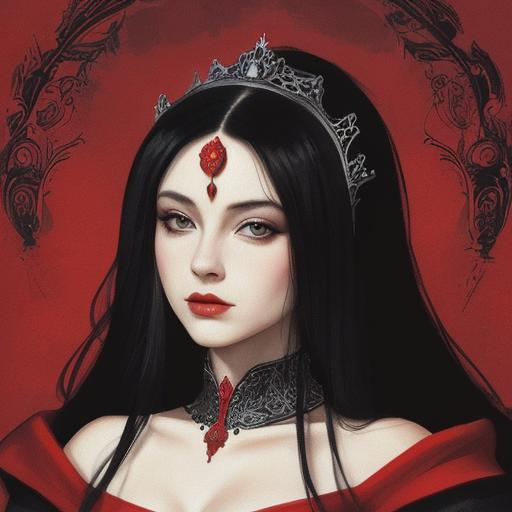

In [13]:
display(prompt)
display(neg_prompt)
display(seed)
display(n_steps)
display(guidance_scale)
display(primary_button)

In [14]:
print("Done")

Done
